<a href="https://colab.research.google.com/github/weso500/QMLPublicationRuns/blob/main/ComparerunsFault15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install qiskit

In [7]:
pip install qiskit-machine-learning

In [8]:
pip install pyreadr

In [9]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [10]:
df_FaultFree = pyreadr.read_r(r'/content/drive/MyDrive/FDA Journal/TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'/content/drive/MyDrive/FDA Journal/TEP_Faulty_Training.RData')['faulty_training']

In [11]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [12]:
columns_to_keep = [
    'faultNumber',
    'simulationRun',
    'sample',

    # Feed and composition inputs (root cause)
    'xmeas_1',   # A feed flow
    'xmeas_2',   # D feed flow
    'xmeas_3',   # E feed flow
    'xmv_1',     # A feed valve (control)
    'xmv_2',     # D feed valve (control)

    # Reactor and process response
    'xmeas_9',   # Reactor temperature (reaction heat shift)
    'xmeas_11',  # Separator temperature (phase changes)
    'xmeas_18',  # Stripper temperature (downstream thermal effect)

    # Product composition indicators
    'xmeas_35',  # Composition of G purge
    'xmeas_33',  # Composition of E purge
    'xmeas_41',  # Composition of H product (final composition signature)
]

DF = DF[columns_to_keep]
display(DF.head())


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmv_1,xmv_2,xmeas_9,xmeas_11,xmeas_18,xmeas_35,xmeas_33,xmeas_41
0,0.0,1.0,1,0.25038,3674.0,4529.0,62.881,53.744,120.41,80.044,65.732,4.8436,18.579,43.828
1,0.0,1.0,2,0.25109,3659.4,4556.6,63.132,53.414,120.41,80.078,65.716,4.8436,18.579,43.828
2,0.0,1.0,3,0.25038,3660.3,4477.8,63.117,54.357,120.42,80.220,65.732,4.8543,18.765,43.828
3,0.0,1.0,4,0.24977,3661.3,4512.1,63.100,53.946,120.39,80.305,65.781,4.8543,18.765,43.828
4,0.0,1.0,5,0.29405,3679.0,4497.0,63.313,53.658,120.39,80.064,65.788,4.8304,18.666,43.828


In [22]:

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import PauliFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

dimension = 11
feature_map = PauliFeatureMap(feature_dimension=dimension, reps=1, entanglement="full")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣  Helper utilities
# ============================================================

def center_kernel(K):
    """Center kernel (zero-mean in feature space)."""
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def normalize_kernel(K):
    """Cosine-normalize kernel."""
    d = np.sqrt(np.clip(np.diag(K), 1e-12, None))
    return K / np.outer(d, d)

def kernel_target_alignment(K, y):
    """KTA between kernel and label kernel."""
    y = y * 2 - 1  # 0/1 → -1/+1
    Y = np.outer(y, y)
    num = np.sum(K * Y)
    denom = np.sqrt(np.sum(K * K) * np.sum(Y * Y))
    return num / denom

def hsic(K, y):
    """Hilbert–Schmidt Independence Criterion."""
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    L = np.outer(y, y)
    return np.trace(H @ K @ H @ L) / ((n - 1)**2)

def mmd(K_xx, K_yy, K_xy):
    """Maximum Mean Discrepancy."""
    return K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()

def cka(K1, K2):
    """Centered Kernel Alignment between two kernels."""
    K1c, K2c = center_kernel(K1), center_kernel(K2)
    num = np.sum(K1c * K2c)
    denom = np.sqrt(np.sum(K1c**2) * np.sum(K2c**2))
    return num / denom

def kernel_spectrum(K):
    """Return normalized eigenvalue spectrum."""
    Kc = center_kernel(K)
    eigvals = np.sort(np.linalg.eigvalsh(Kc))[::-1]
    eigvals = np.clip(eigvals, 0, None)
    return eigvals / eigvals.sum()

# ============================================================
# 2️⃣  Build consistent data split
# ============================================================

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def get_split(DF, fault_id=3, n_train_normals=100, n_test_normals=70, n_test_faulty=5, seed=42):
    """
    Build train/test split for fault detection without data leakage.
    The StandardScaler is fit ONLY on the normal training subset.
    """

    # --- Filter subsets ---
    fault_free = DF[DF["faultNumber"] == 0].iloc[::50, 3:]
    fault_subset = DF[DF["faultNumber"] == fault_id].iloc[::30, 3:]

    # --- Sampling ---
    rng = np.random.RandomState(seed)
    train_df = fault_free.sample(n=n_train_normals, random_state=seed)
    remaining = fault_free.drop(train_df.index)
    test_normals_df = remaining.sample(n=min(n_test_normals, len(remaining)), random_state=seed + 100)
    test_faulty_df = fault_subset.sample(n=min(n_test_faulty, len(fault_subset)), random_state=seed + 200)

    # --- Fit scaler ONLY on training data ---
    sc = StandardScaler()
    sc.fit(train_df.values)

    # --- Apply scaling ---
    X_train = sc.transform(train_df.values)
    X_test_norm = sc.transform(test_normals_df.values)
    X_test_fault = sc.transform(test_faulty_df.values)

    # --- Concatenate for convenience ---
    X = np.vstack([X_train, X_test_norm, X_test_fault])
    y = np.concatenate([
        np.zeros(len(X_train) + len(X_test_norm), dtype=int),
        np.ones(len(X_test_fault), dtype=int)
    ])

    return X, y, sc


# ============================================================
# 3️⃣  Compute and compare kernels
# ============================================================

def compare_kernels(DF, kernel, fault_id=3, gamma='scale', alpha=5.0, nystrom_components=64, seed=42):
    X, y, sc = get_split(DF, fault_id, seed=seed)

    # --- Classical RBF kernel ---
    if gamma == 'scale':
        gamma_val = 1.0 / (X.shape[1] * X.var())
    elif gamma == 'auto':
        gamma_val = 1.0 / X.shape[1]
    else:
        gamma_val = float(gamma)
    K_rbf = rbf_kernel(X, gamma=gamma_val)
    K_rbf = normalize_kernel(center_kernel(K_rbf))

    # --- Quantum Nyström kernel ---
    Xq = alpha * X
    Phi = Nystroem(kernel=lambda A, B=None: kernel.evaluate(x_vec=A, y_vec=B),
                   n_components=min(nystrom_components, len(Xq)-1),
                   random_state=seed)
    Z = Phi.fit_transform(Xq)
    K_q = normalize_kernel(center_kernel(Z @ Z.T))

    # --- Diagnostics ---
    idx_norm = (y == 0)
    idx_fault = (y == 1)

    KTA_rbf = kernel_target_alignment(K_rbf, y)
    KTA_q = kernel_target_alignment(K_q, y)

    HSIC_rbf = hsic(K_rbf, y)
    HSIC_q = hsic(K_q, y)

    Kxx_r, Kyy_r = K_rbf[np.ix_(idx_norm, idx_norm)], K_rbf[np.ix_(idx_fault, idx_fault)]
    Kxy_r = K_rbf[np.ix_(idx_norm, idx_fault)]
    MMD_rbf = mmd(Kxx_r, Kyy_r, Kxy_r)

    Kxx_q, Kyy_q = K_q[np.ix_(idx_norm, idx_norm)], K_q[np.ix_(idx_fault, idx_fault)]
    Kxy_q = K_q[np.ix_(idx_norm, idx_fault)]
    MMD_q = mmd(Kxx_q, Kyy_q, Kxy_q)

    CKA_val = cka(K_rbf, K_q)

    # --- Spectra ---
    eig_rbf = kernel_spectrum(K_rbf)
    eig_q = kernel_spectrum(K_q)

    # --- Report ---
    summary = pd.DataFrame({
        "Metric": ["KTA", "HSIC", "MMD", "CKA (vs RBF)"],
        "RBF": [KTA_rbf, HSIC_rbf, MMD_rbf, np.nan],
        "Quantum": [KTA_q, HSIC_q, MMD_q, CKA_val]
    })
    print("\n=== Kernel Diagnostics (Fault {}) ===".format(fault_id))
    display(summary)

    # --- Plot spectra ---
    plt.figure(figsize=(6,4))
    plt.semilogy(eig_rbf, 'o-', label='RBF Spectrum')
    plt.semilogy(eig_q, 's-', label='Quantum Spectrum')
    plt.title(f"Kernel Eigenvalue Spectrum (Fault {fault_id})")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Normalized Magnitude (log scale)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return summary, eig_rbf, eig_q



=== Kernel Diagnostics (Fault 15) ===


,Metric,RBF,Quantum
0,KTA,0.009025,0.470478
1,HSIC,0.000134,0.000130
2,MMD,0.171729,0.166971
3,CKA (vs RBF),NaN,0.082056


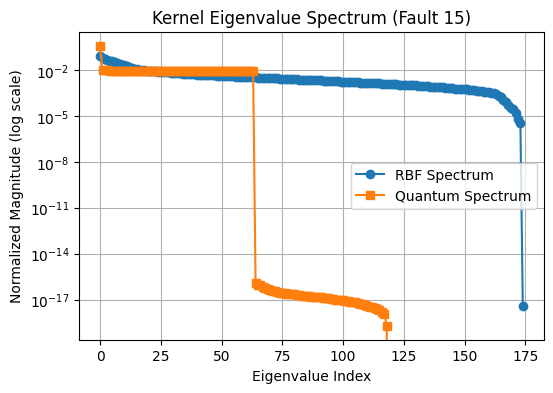

In [18]:

dimension = 11
feature_map = PauliFeatureMap(feature_dimension=dimension, reps=1, entanglement="full")
sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# Run diagnostics for a chosen fault
summary, eig_rbf, eig_q = compare_kernels(DF, kernel, fault_id=15, gamma='scale', alpha=5.0)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, sigmoid_kernel, linear_kernel
from sklearn.kernel_approximation import Nystroem

# ============================================================
# 1️⃣  Helper utilities
# ============================================================

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def normalize_kernel(K):
    d = np.sqrt(np.clip(np.diag(K), 1e-12, None))
    return K / np.outer(d, d)

def kernel_target_alignment(K, y):
    y = y * 2 - 1
    Y = np.outer(y, y)
    num = np.sum(K * Y)
    denom = np.sqrt(np.sum(K * K) * np.sum(Y * Y))
    return num / denom

def hsic(K, y):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    L = np.outer(y, y)
    return np.trace(H @ K @ H @ L) / ((n - 1)**2)

def mmd(K_xx, K_yy, K_xy):
    return K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()

def cka(K1, K2):
    K1c, K2c = center_kernel(K1), center_kernel(K2)
    num = np.sum(K1c * K2c)
    denom = np.sqrt(np.sum(K1c**2) * np.sum(K2c**2))
    return num / denom

def kernel_spectrum(K):
    Kc = center_kernel(K)
    eigvals = np.sort(np.linalg.eigvalsh(Kc))[::-1]
    eigvals = np.clip(eigvals, 0, None)
    s = eigvals.sum()
    return eigvals / s if s > 0 else eigvals

# ============================================================
# 2️⃣  Leakage-free data split
# ============================================================

def get_split(DF, fault_id=3, n_train_normals=100, n_test_normals=70, n_test_faulty=5, seed=42):
    fault_free = DF[DF["faultNumber"] == 0].iloc[::50, 3:]
    fault_subset = DF[DF["faultNumber"] == fault_id].iloc[::30, 3:]

    train_df = fault_free.sample(n=n_train_normals, random_state=seed)
    remaining = fault_free.drop(train_df.index)
    test_normals_df = remaining.sample(n=min(n_test_normals, len(remaining)), random_state=seed + 100)
    test_faulty_df = fault_subset.sample(n=min(n_test_faulty, len(fault_subset)), random_state=seed + 200)

    sc = StandardScaler()
    sc.fit(train_df.values)

    X_train = sc.transform(train_df.values)
    X_test_norm = sc.transform(test_normals_df.values)
    X_test_fault = sc.transform(test_faulty_df.values)

    X = np.vstack([X_train, X_test_norm, X_test_fault])
    y = np.concatenate([
        np.zeros(len(X_train) + len(X_test_norm), dtype=int),
        np.ones(len(X_test_fault), dtype=int)
    ])

    return X, y, sc

# ============================================================
# 3️⃣  Multi-kernel comparison
# ============================================================

def compare_multiple_kernels(DF, qkernel, fault_id=3, gamma='scale', alpha=5.0, nystrom_components=64, seed=42):
    X, y, _ = get_split(DF, fault_id=fault_id, seed=seed)

    if gamma == 'scale':
        gamma_val = 1.0 / (X.shape[1] * X.var())
    elif gamma == 'auto':
        gamma_val = 1.0 / X.shape[1]
    else:
        gamma_val = float(gamma)

    kernels = {}

    # --- Classical kernels ---
    kernels["RBF"] = rbf_kernel(X, gamma=gamma_val)
    kernels["Polynomial (deg=3)"] = polynomial_kernel(X, degree=3, gamma=gamma_val, coef0=1)
    kernels["Sigmoid"] = sigmoid_kernel(X, gamma=gamma_val, coef0=1)
    kernels["Linear"] = linear_kernel(X)

    # --- Quantum kernel ---
    Xq = alpha * X
    Phi = Nystroem(
        kernel=lambda A, B=None: qkernel.evaluate(x_vec=A, y_vec=B),
        n_components=(len(Xq) - 1),
        random_state=seed
    )
    Z = Phi.fit_transform(Xq)
    kernels["Quantum"] = Z @ Z.T

    # --- Center and normalize ---
    for k in kernels:
        kernels[k] = normalize_kernel(center_kernel(kernels[k]))

    idx_norm = (y == 0)
    idx_fault = (y == 1)

    # --- Collect metrics ---
    summaries = []
    for name, K in kernels.items():
        KTA = kernel_target_alignment(K, y)
        HSIC_val = hsic(K, y)

        Kxx, Kyy = K[np.ix_(idx_norm, idx_norm)], K[np.ix_(idx_fault, idx_fault)]
        Kxy = K[np.ix_(idx_norm, idx_fault)]
        MMD_val = mmd(Kxx, Kyy, Kxy)

        summaries.append({
            "Kernel": name,
            "KTA": KTA,
            "HSIC": HSIC_val,
            "MMD": MMD_val
        })

    summary_df = pd.DataFrame(summaries).set_index("Kernel")

    # --- Compute pairwise CKA vs RBF ---
    ref = kernels["RBF"]
    summary_df["CKA vs RBF"] = [cka(ref, kernels[k]) for k in kernels.keys()]

    # --- Plot eigen spectra ---
    plt.figure(figsize=(7, 5))
    for name, K in kernels.items():
        eigvals = kernel_spectrum(K)
        plt.semilogy(eigvals, label=name)
    plt.title(f"Kernel Eigenvalue Spectra (Fault {fault_id})")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Normalized Magnitude (log scale)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n=== Multi-Kernel Diagnostics (Fault {fault_id}) ===")
    display(summary_df)

    return summary_df, kernels


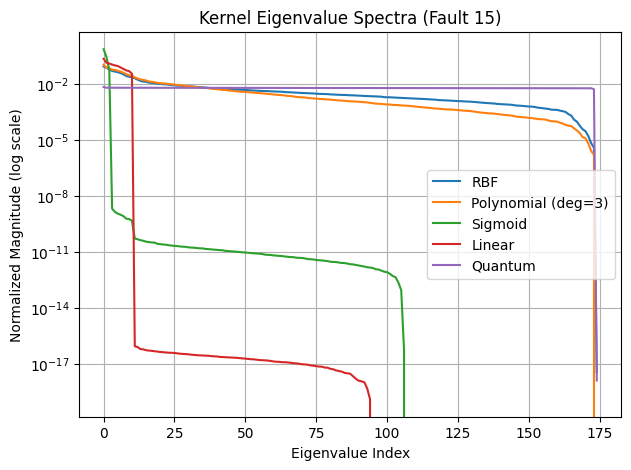


=== Multi-Kernel Diagnostics (Fault 15) ===


,KTA,HSIC,MMD,CKA vs RBF
Kernel,,,,
RBF,0.009025,0.000134,1.717291e-01,1.000000
Polynomial (deg=3),0.047866,0.000135,1.728906e-01,0.964502
Sigmoid,-0.022140,-11670.890588,-1.497755e+07,-0.113428
Linear,0.004759,0.000125,1.601190e-01,0.793506
Quantum,0.008809,0.000161,2.067882e-01,0.456119


In [26]:

# --- Define quantum kernel ---
dimension = 11
feature_map = PauliFeatureMap(feature_dimension=dimension, reps=1, entanglement="full")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# --- Run diagnostics on a chosen fault ---
summary, kernels = compare_multiple_kernels(DF, qkernel, fault_id=15, gamma='scale', alpha=5.0)
